In [2]:
#!pip install -q --upgrade pandas
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from pprint import pprint
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import pandas as pd

#projects1_1 = pd.read_csv('kickstarter-projects/ks-projects-201612.csv', encoding='latin1')
projects1 = pd.read_csv('kickstarter-projects/ks-projects-201801.csv')
projects2 = pd.read_csv('funding-successful-projects-on-kickstarter/train.csv')

In [3]:
pd.__version__

'0.22.0'

In [4]:
projects = projects1.merge(projects2, on='name', how='inner')
projects = projects.dropna()
projects.columns

Index(['ID', 'name', 'category', 'main_category', 'currency_x', 'deadline_x',
       'goal_x', 'launched', 'pledged', 'state', 'backers', 'country_x',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real', 'project_id',
       'desc', 'goal_y', 'keywords', 'disable_communication', 'country_y',
       'currency_y', 'deadline_y', 'state_changed_at', 'created_at',
       'launched_at', 'backers_count', 'final_status'],
      dtype='object')

In [5]:
import numpy as np

renames = {
    'country_x': 'country',
    'currency_x': 'currency',
    'usd_goal_real': 'goal',
    'usd_pledged_real': 'pledged',
    'country_y': 'country',
    'currency_y': 'currency',
    'deadline_y': 'deadline',
    'backers_count': 'backers'
}

to_num = lambda x: pd.to_numeric(x, errors='coerce')
to_date = lambda x: pd.to_datetime(x, unit='s')
conversions = {
    'backers': to_num,
    'deadline': to_date,
    'launched_at': to_date,
    'state_changed_at': to_date,
    'created_at': to_date,
    'goal': to_num,
    'pledged': to_num,
}

drops = (
    'ID', 'project_id', 'keywords', 'deadline_x', 
    'disable_communication', 
    'goal_x', 'goal_y', 'usd pledged'
)

In [6]:
def clean_df(df, renames=None, retypes=None, drops=None):
    if renames is not None:
        for orig, new in renames.items():
            if new in df.columns:
                diffs = df[[orig, new]][df[orig] != df[new]]
                print("The following columns showed differences when renaming!")
                print(diffs[:10])
                df[new] = df[orig]
                df = df.drop(orig, axis=1)
            else:
                df = df.rename(columns={orig: new})
    if retypes is not None:
        for col, conv in retypes.items():
            dfcol = df[col]
            df = df.drop(col, axis=1)
            df[col] = conv(dfcol)
    if drops is not None:
        for col in drops:
            df = df.drop(col, axis=1)
            
    df = df.dropna(axis=1, how='all')
    df = df.dropna(axis=0, how='any')
    return df
            
cleaned = clean_df(projects, renames, conversions, drops)   

The following columns showed differences when renaming!
    usd_pledged_real  pledged
4               6.29     48.0
5           42174.03  48905.0
6              31.09     21.0
25              2.36      3.0
29           9110.34  11336.0
40           1122.89    756.0
44            485.72    293.0
47             16.58     10.0
49            628.47    656.0
57           4848.23   3097.0
The following columns showed differences when renaming!
    country_y country
109        US      GB
128        US      GB
345        US      CA
347        US      GB
398        US      GB
399        US      GB
416        CA      US
432        US      CA
863        US      AU
896        GB      US
The following columns showed differences when renaming!
    currency_y currency
109        USD      GBP
128        USD      GBP
345        USD      CAD
347        USD      GBP
398        USD      GBP
399        USD      GBP
416        CAD      USD
432        USD      CAD
863        USD      AUD
896        GBP      

In [128]:
from scipy import stats

cleaned['desc_len'] = cleaned.desc.str.len()

try:
    ######################
    ## I'm filtering out projects that lasted less than a day. 
    ## (Seems to be about 1,000 of them)
    ######################
    cleaned['duration'] = cleaned['deadline'] - cleaned['launched_at']
    real_duration = cleaned['state_changed_at'] - cleaned['launched_at']
    cleaned = cleaned[real_duration > pd.Timedelta(days=1)]
except Exception:
    print("Couldn't create duration or filter dataset")
    pass

cleaned = cleaned[cleaned['goal'] > 100]
cleaned = cleaned[cleaned['goal'] <= 2e6]
cleaned = cleaned[(cleaned.state == 'successful') | (cleaned.state == 'failed') | (cleaned.state == 'canceled')]
cleaned = cleaned[(cleaned.country == 'US')]

In [129]:
pd.pivot_table(cleaned, columns=['country'])

country,US
backers,142.714087
desc_len,130.522383
final_status,0.345672
goal,18513.129874
pledged,11424.077370


In [130]:
pd.pivot_table(cleaned, columns=['state'])

state,failed,successful
backers,19.684245,277.845225
desc_len,129.838995,131.272990
final_status,0.005970,0.718787
goal,26277.283529,9985.288973
pledged,1393.555579,22441.207862


In [131]:
cleaned.groupby('country').size()

country
US    80640
dtype: int64

In [132]:
cleaned = cleaned[(cleaned.state == 'successful') | (cleaned.state == 'failed')]

In [133]:
import traceback

def cannot_crash(fn):
    def inner(*args, **kwargs):
        try:
            return fn(*args, **kwargs)
        except Exception:
            print(traceback.format_exc())
    return inner
            

In [134]:
import numpy as np
import matplotlib.pyplot as plt

@cannot_crash
def summarize(df):
    n_failed = np.count_nonzero(df.state == 'failed')
    print("{} Failed".format(n_failed))
    n_success = np.count_nonzero(df.state == 'successful')
    print("{} Success".format(n_success))
 
@cannot_crash
def hist_by_group(df, groupname, n_groups=None):
    if n_groups is None:
        grouped = df.groupby(groupname)
        names = grouped.groups.keys()
    else:
        pcts = np.arange(0, 1, 1/float(n_groups))
        quantiles = df[groupname].quantile(pcts)
        inds = np.digitize(df[groupname], quantiles)
        grouped = df.groupby(inds)
        names = []
        for a, b in zip(pcts, pcts[1:]):
            names.append('{}-{}'.format(quantiles[a], quantiles[b]))
        names.append('{}-{}'.format(quantiles[b], max(df[groupname])))
    
    num_groups = len(grouped)
    
    successes = []
    failures = []

    margins = []
    totals = []
    
    for name, group in grouped:

        n_failed = np.count_nonzero(group.state == 'failed')
        n_success = np.count_nonzero(group.state == 'successful')
        successes.append(float(n_success) / len(group))
        failures.append(float(n_failed) / len(group))
        
        margins.append(np.abs(n_success - n_failed))
        totals.append(n_success + n_failed)
    
    
    
    bar_width = .25
    indices = np.arange(num_groups)
    
    plt.bar(indices, successes, bar_width, color='g', label='succes')
    plt.bar(indices + bar_width, failures, bar_width, color='r', label='failures')
    plt.xticks(indices + bar_width * 1.5, names)
    plt.gca().set_ylabel("Percentage")
    plt.gca().set_xlabel(groupname)
    plt.legend()
   
@cannot_crash
def rolling_success(df):
    
    statuses = df[(df['state'] == 'failed') | (df['state'] == 'successful')]
    
    statuses['succeeded'] = statuses['state'] == 'successful'
    
    grouped = statuses.groupby((statuses['goal'] / 1000).astype(int))

    not_alone = grouped.size() > 10
    
    success_rate = grouped['succeeded'].mean()[not_alone]
    
    ax = plt.subplot()
    print(success_rate.shape)
    plt.plot(success_rate.index, success_rate, '.')
    ax.set_xscale('log')
    ax.set_xlabel("Goal")
    ax.set_ylabel("Success Ratio")

@cannot_crash
def success_over_time(df, col):
    creations = df['created_at'].astype(np.int64)
    quantiles = creations.quantile(np.arange(0, 1, .1))
    inds = np.digitize(creations, quantiles)
    grouped = df.groupby(inds)
    
    unique_cols = df[col].unique()
    
    dates = []
    data = []
    names = []
    for unique_col in unique_cols:
        col_data = []
        for _, group in grouped:
            group = group[group[col] == unique_col]
            n_failed = np.count_nonzero(group.state == 'failed')
            n_success = np.count_nonzero(group.state == 'successful')
            col_data.append(float(n_success) / len(group))
        data.append(col_data)
        names.append(unique_col)

    all_data = []
    for _, group in grouped:
        n_failed = np.count_nonzero(group.state == 'failed')
        n_success = np.count_nonzero(group.state == 'successful')
        all_data.append(float(n_success) / len(group))

        
    for q in quantiles:
        dates.append(np.datetime64(int(q), 's'))
        
    fig, ax = plt.subplots()
    for dat in data:
        ax.plot(dates, dat)
    
    ax.plot(dates, all_data, 'k', linewidth=3)
    
    plt.legend(names + ['All'])
    plt.show()
        
    

<IPython.core.display.Javascript object>


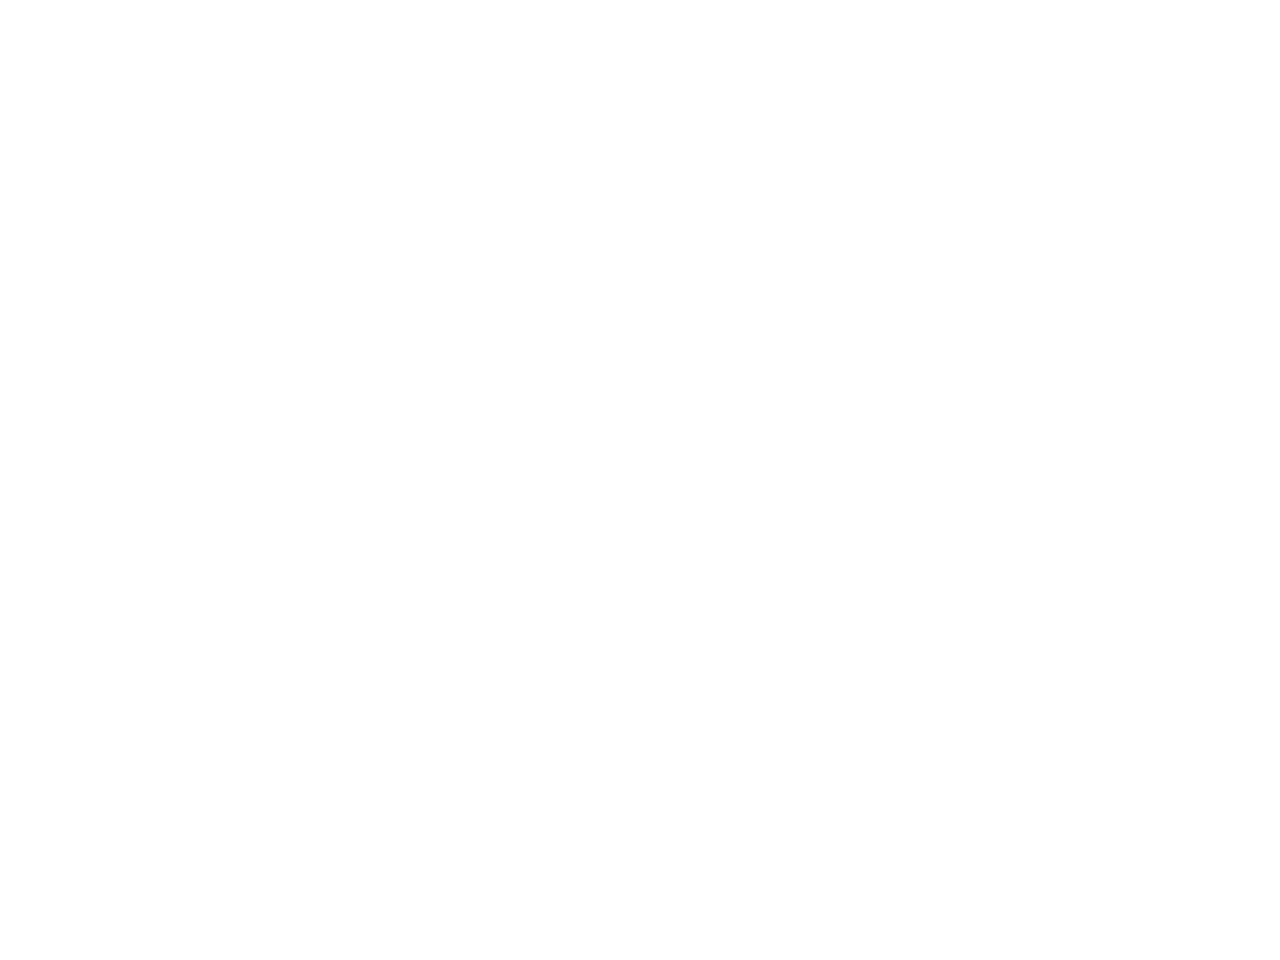

In [135]:
%matplotlib notebook

success_over_time(cleaned, 'main_category')


42210 Failed
38430 Success


<IPython.core.display.Javascript object>


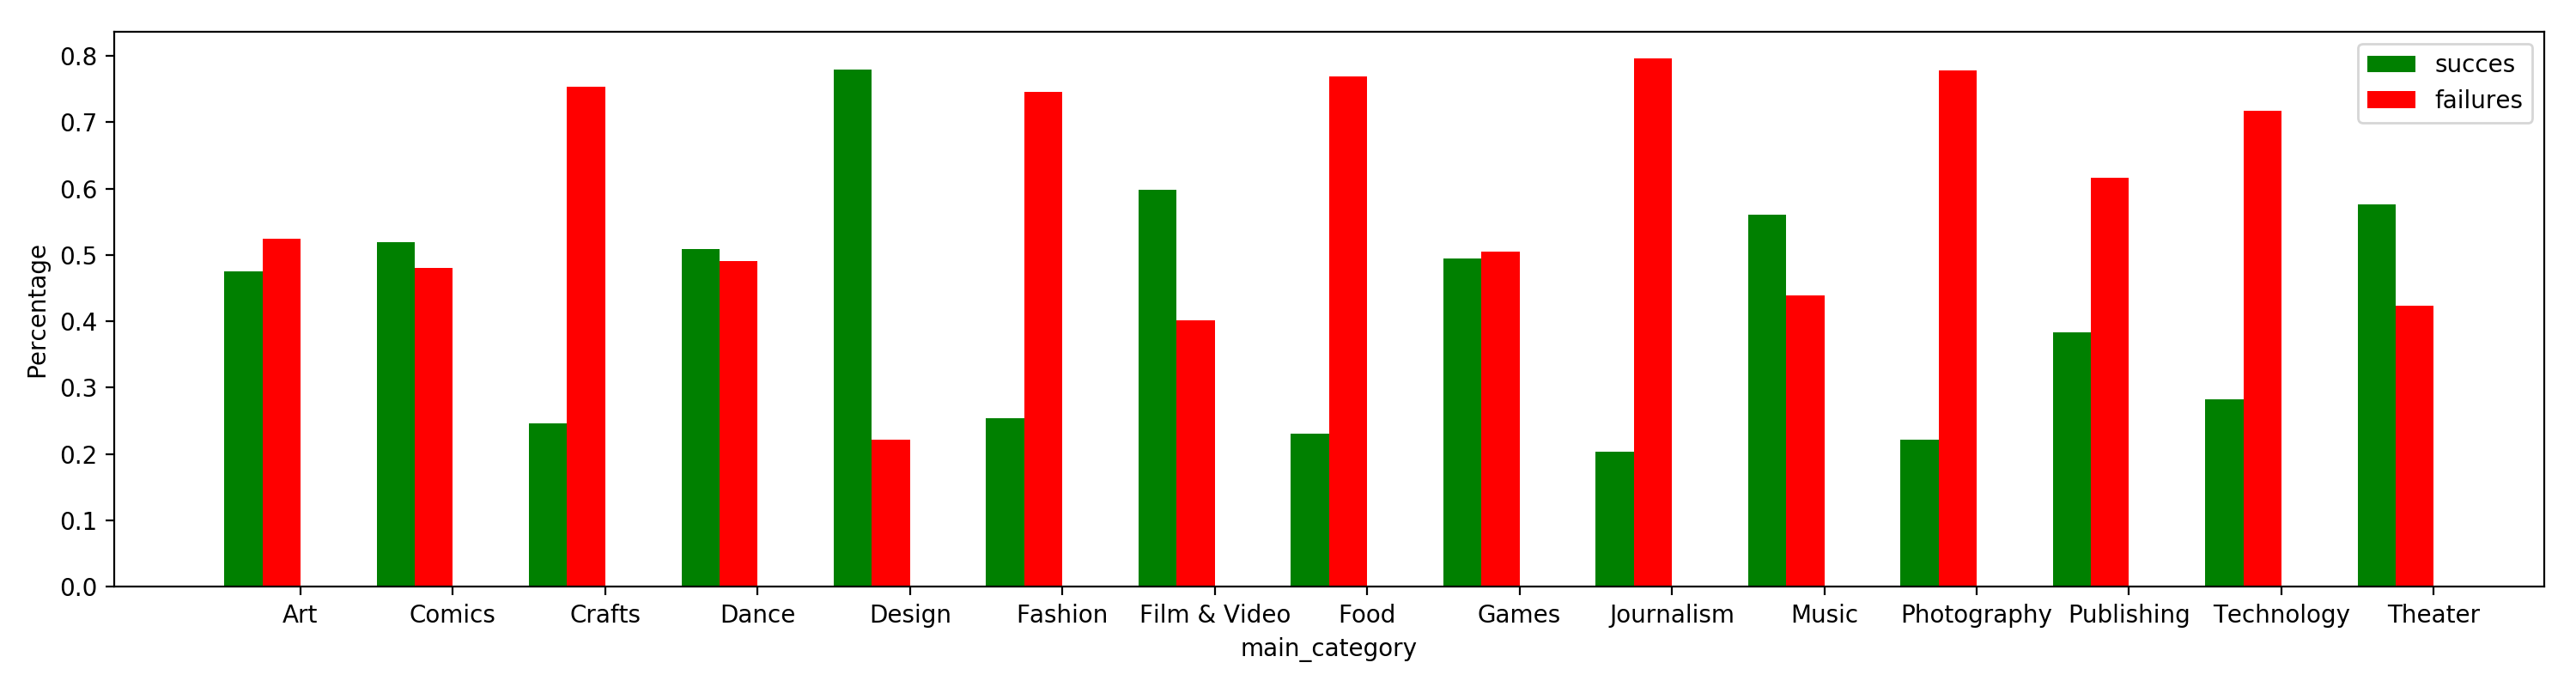

<IPython.core.display.Javascript object>


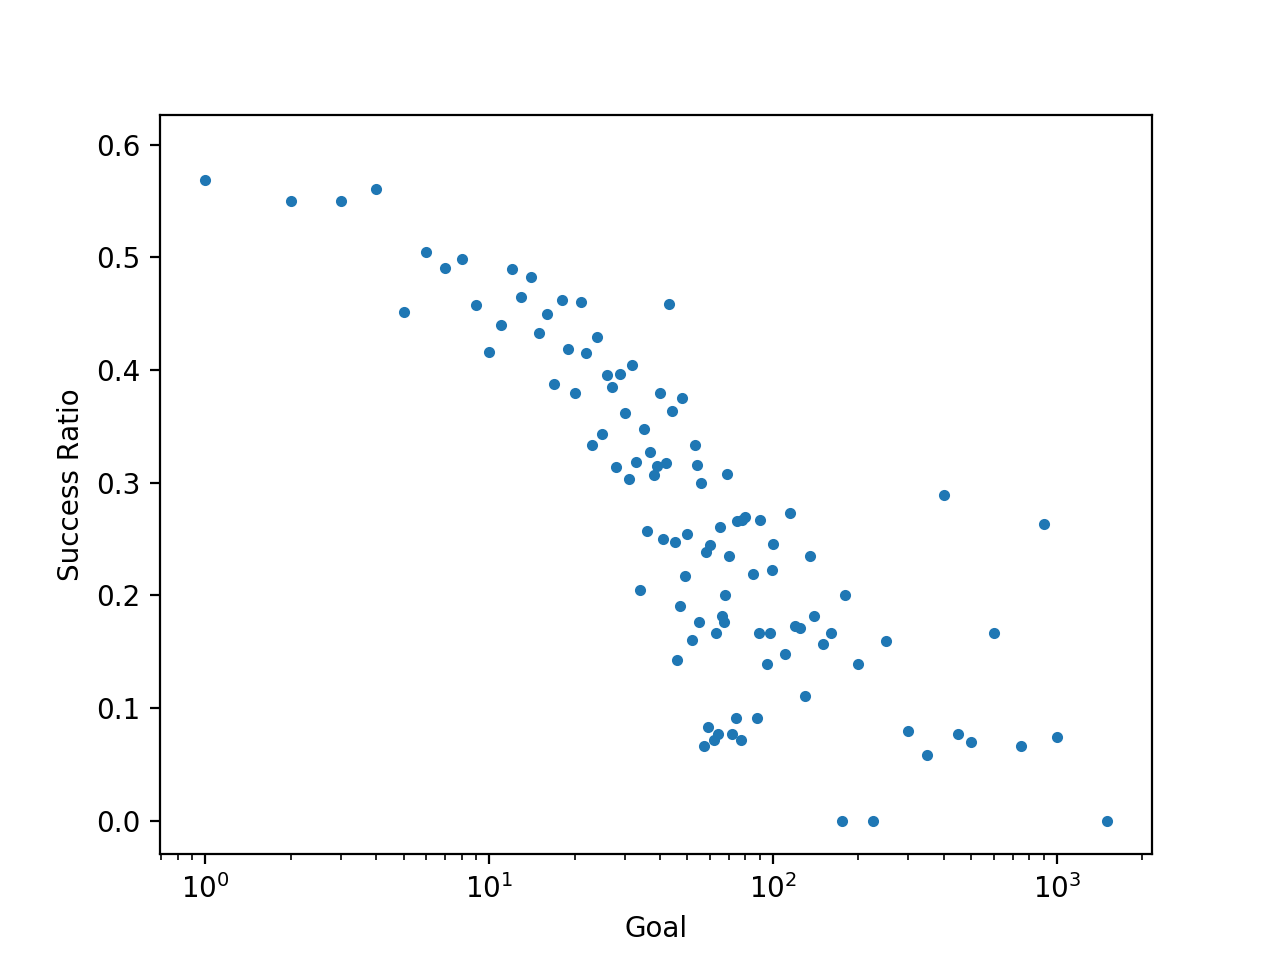

(107,)


In [136]:
%matplotlib notebook

summarize(cleaned)
plt.figure(figsize=(15, 4))
hist_by_group(cleaned, 'main_category')
plt.tight_layout()

plt.figure()
rolling_success(cleaned)



<IPython.core.display.Javascript object>


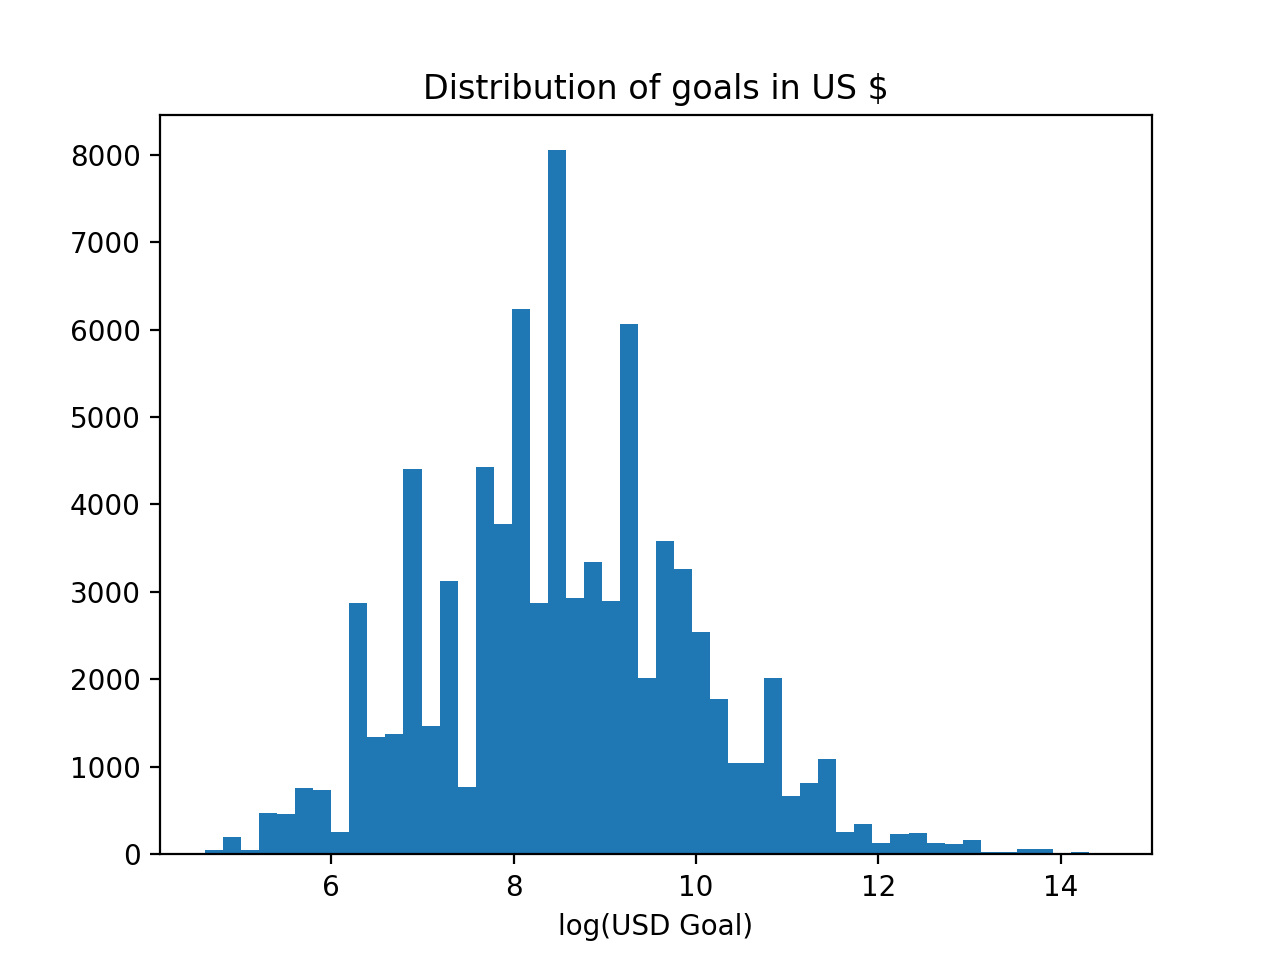

In [137]:
@cannot_crash
def show_goal_hist():
    fig, ax = plt.subplots()
    ax.hist(np.log(cleaned['goal']), 50)
    plt.show()
    plt.xlabel("log(USD Goal)")
    plt.title("Distribution of goals in US $")
    
show_goal_hist()

In [16]:
@cannot_crash
def goal_percent_comparison(successes, failures, canceled=None):
    ax = plt.subplot()
    plt.plot(successes.goal, successes.pledged/successes.goal, 'g.', alpha=.2)
    plt.plot(failures.goal, failures.pledged/failures.goal, 'r.', alpha=.2)
    if canceled is not None:
        plt.plot(canceled.goal, canceled.pledged/canceled.goal, 'y.', alpha=.2)
    ax.set_xscale('log')
    ax.set_xlabel('Goal')
    ax.set_ylabel('% Of Goal Reached')
    plt.ylim([0, 2])
    plt.legend(['successes','failures', 'canceled'])

<IPython.core.display.Javascript object>


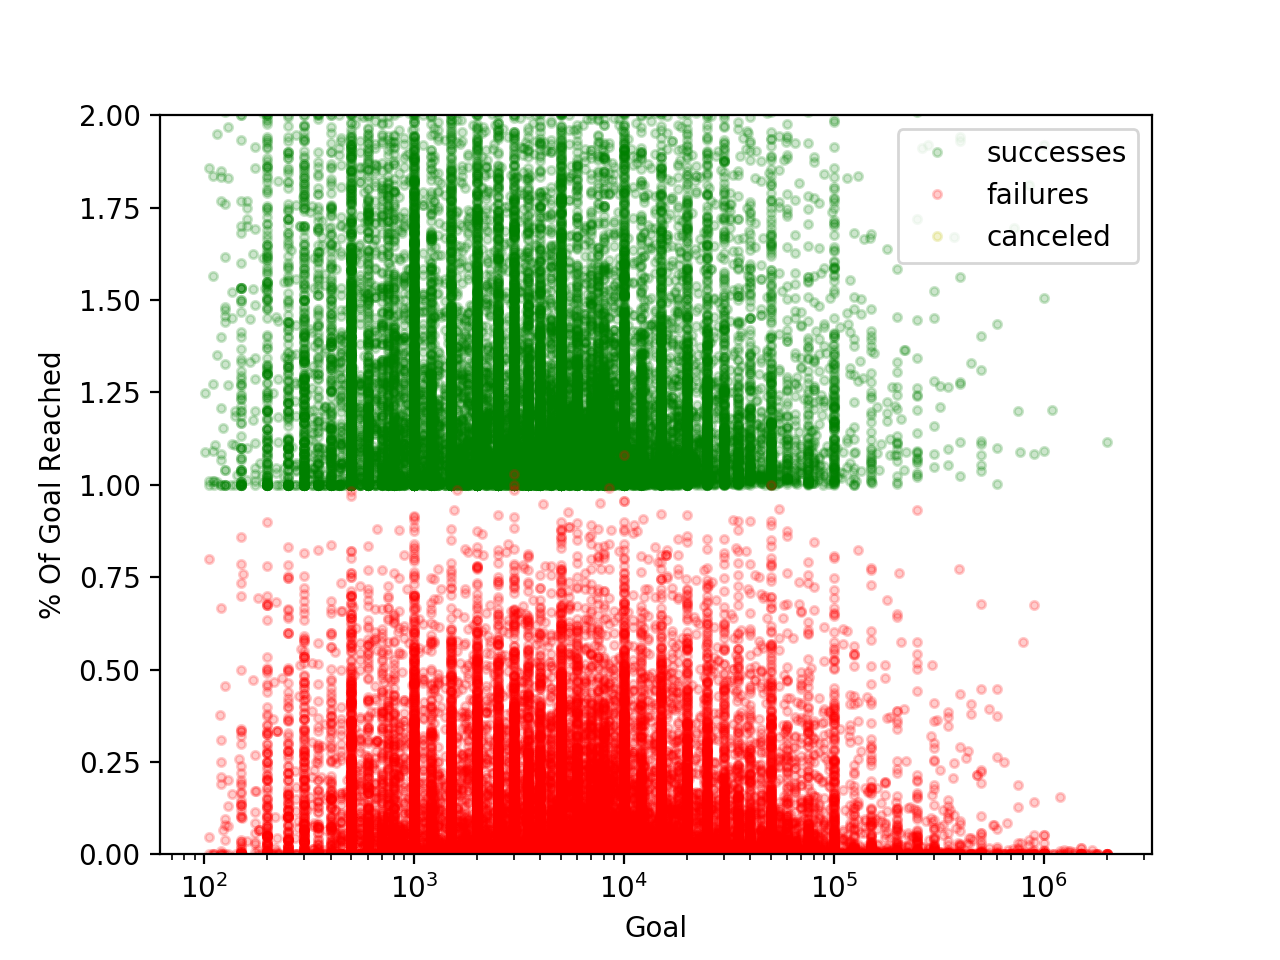

In [138]:
%matplotlib notebook
import matplotlib.pyplot as plt

plt.figure()
successes = cleaned[cleaned.state == 'successful']
failures = cleaned[cleaned.state == 'failed']
canceled = cleaned[cleaned.state == 'canceled']

goal_percent_comparison(successes,failures, canceled)


In [139]:
import copy
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
import re

wnl = WordNetLemmatizer()
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

n_lemmatized = 0    
def lemmatize_text(text):
    global n_lemmatized
    if n_lemmatized % 10000 == 0:
        print(".", end='', flush=True)
    n_lemmatized+= 1
        
    words = []
    for word, pos in nltk.pos_tag(word_tokenize(text)):
        word = word.lower()
        pos = get_wordnet_pos(pos)
        if pos != '':
            words.append(wnl.lemmatize(word, pos))
        elif re.match("[a-z-]+'?[a-z]*", word):
            words.append(wnl.lemmatize(word))
    return ' '.join(words)

def do_lemmatize(df):
    df = copy.deepcopy(df)

    print("Lemmatizing description (this will take a while)")
    df['desc'] = df['desc'].apply(lemmatize_text)
    print("Lemmatizing name (this will take a while)")
    df['name'] = df['name'].apply(lemmatize_text)
    return df
    
lemmatized = do_lemmatize(cleaned)       

Lemmatizing description (this will take a while)
.........Lemmatizing name (this will take a while)
........

In [140]:
lemmatized

,name,category,main_category,currency,launched,state,country,desc,final_status,backers,deadline,launched_at,state_changed_at,created_at,goal,pledged,desc_len,duration
0,where be hank,Narrative Film,Film & Video,USD,2013-01-12 00:20:50,failed,US,abandon property sound of struggle muffle guns...,0,3,2013-02-25 23:20:50,2013-01-11 23:20:50,2013-02-25 23:20:50,2013-01-08 00:01:24,45000.0,220.00,106,45 days 00:00:00
2,the beard,Comic Books,Comics,USD,2014-10-09 22:27:52,failed,US,beard be a comedy base comic about an average ...,0,16,2014-11-08 21:27:52,2014-10-09 20:27:52,2014-11-08 21:27:52,2014-10-01 14:14:02,1500.0,395.00,129,30 days 01:00:00
3,note from london above below,Art Books,Publishing,USD,2015-04-10 21:20:54,failed,US,note from london above below be an unusual col...,0,20,2015-05-10 19:20:54,2015-04-10 19:20:54,2015-05-10 19:20:55,2015-04-08 20:56:45,3000.0,789.00,132,30 days 00:00:00
7,bb130a,Public Art,Art,USD,2013-02-12 01:07:28,failed,US,this monumental event will exhibit how people ...,0,30,2013-03-23 23:07:28,2013-02-12 00:07:28,2013-03-23 23:07:28,2013-02-09 02:27:52,25000.0,1395.00,132,39 days 23:00:00
8,arrow sound debut album,Indie Rock,Music,USD,2012-04-19 01:04:31,successful,US,philip zach formerly of remedy drive be record...,1,157,2012-05-18 23:04:31,2012-04-18 23:04:31,2012-05-18 23:04:31,2012-02-01 17:19:44,4000.0,8641.34,122,30 days 00:00:00
9,help scott reynolds make a new record,Indie Rock,Music,USD,2012-08-03 18:43:16,successful,US,it 's be year since his last release he 's get...,1,277,2012-09-02 16:43:16,2012-08-03 16:43:16,2012-09-02 16:43:17,2012-04-16 21:22:36,15000.0,17499.99,134,30 days 00:00:00
10,the please please me studio premiere,Pop,Music,USD,2012-07-15 03:27:33,successful,US,poetry you can dance to,1,181,2012-09-01 21:36:00,2012-07-15 01:27:33,2012-09-01 21:36:00,2012-06-22 22:23:09,10000.0,12656.00,279,48 days 20:08:27
11,hot chicken take over,Restaurants,Food,USD,2014-09-16 02:31:08,successful,US,for hot chicken to really takeover - we need y...,1,855,2014-10-16 03:59:00,2014-09-16 00:31:08,2014-10-16 03:59:00,2014-09-03 00:36:02,40000.0,63401.00,55,30 days 03:27:52
12,star and the snowman,Narrative Film,Film & Video,USD,2013-01-24 06:04:05,successful,US,star and the snowman be the story of two peopl...,1,154,2013-02-23 05:04:05,2013-01-24 05:04:05,2013-02-23 05:04:05,2012-10-30 13:34:43,8000.0,9401.00,624,30 days 00:00:00
13,sea of iron,Tabletop Games,Games,USD,2013-06-19 03:16:33,successful,US,a good navy be not a provocation to war it be ...,1,218,2013-07-19 01:16:33,2013-06-19 01:16:33,2013-07-19 01:16:34,2013-03-01 06:18:11,3000.0,8105.00,363,30 days 00:00:00


In [141]:
cleaned.created_at.iloc[0] > cleaned.created_at.iloc[1] - pd.Timedelta('180 days')

False

In [142]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

vectorizer.fit(lemmatized.desc.map(str) + " " + lemmatized.name)

desc_full_tfidf = vectorizer.transform(lemmatized.desc)
name_full_tfidf = vectorizer.transform(lemmatized.name)

In [143]:
print(lemmatized.desc.iloc[9])
print(desc_full_tfidf[9,:][desc_full_tfidf[9,:].nonzero()])

a good navy be not a provocation to war it be the sure guaranty of peace — president theodore roosevelt
[[ 0.19072143  0.06063273  0.35711483  0.05078829  0.25835624  0.33755711
   0.40556372  0.28181255  0.23115566  0.06351568  0.17106239  0.3065472
   0.11004087  0.40556372  0.17509896  0.13150774]]


In [144]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(100)
desc_svd = svd.fit_transform(desc_full_tfidf)
name_svd = svd.fit_transform(name_full_tfidf)

text_svd = np.concatenate([desc_svd, name_svd], 1)

In [145]:
import sklearn.preprocessing
scaled_svd = sklearn.preprocessing.scale(text_svd)

In [27]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
from __future__ import print_function
import sys
import re
from sklearn.feature_extraction import DictVectorizer
from collections import defaultdict

wnl = WordNetLemmatizer()

def create_feature_matrix(df,
                          scalars=None,
                          percentiles = None,
                          categoricals=None,
                          splits=None):
    # Should be done using apply or map or something like that
    ds = []
    Y = []
    grps = {}
    
    sorted_pcts = {}
    print("Sorting necessary columns")
    if percentiles:
        for pct in percentiles:
            sorted_pcts[pct] = np.array(sorted(df[pct]))
     
    ds = []   
    
    print("Iterating over rows ")
    for i, r in df.iterrows():
        if i % 10000 == 0:
            print('.', end='')
            sys.stdout.flush()
        d = defaultdict(int)
        if percentiles is not None:
            for pct in percentiles:
                d[pct] = float(np.searchsorted(sorted_pcts[pct], r[pct])) / len(sorted_pcts[pct])
        
        if scalars is not None:
            for sca in scalars:
                try:
                    d[sca] = pd.to_numeric(r[sca])
                except:
                    raise
                    print(":O", sca, d[sca])
                    continue
                           
        if categoricals is not None:
            for cat in categoricals:
                d[cat + r[cat]] = 1
                
        if splits is not None:
            for spl in splits:
                for word in r[spl].split():
                    d[spl+'_'+word.upper()] = 1
                
        ds.append(d)
    
    v = DictVectorizer()
    print("Vectorizing")
    X = v.fit_transform(ds)
    return X.astype(float)


In [146]:
from sklearn.preprocessing import normalize

numerical_features = create_feature_matrix(lemmatized,
    percentiles = ('goal', 'created_at', 'desc_len', 'duration'),
    categoricals = ('category', 'main_category', 'country',)
)
numerical_features

Sorting necessary columns
Iterating over rows 
.........Vectorizing


<80640x177 sparse matrix of type '<class 'numpy.float64'>'
	with 564468 stored elements in Compressed Sparse Row format>

In [147]:
count = 0
window_sim = []

for i, doc in enumerate(text_svd):
    if i % 10000 == 0:
        print('.', end='', flush=True)
    creation = cleaned.created_at.iloc[i]
    mask = (cleaned.created_at < creation) & (cleaned.created_at > creation - pd.Timedelta('30 days'))
    if not mask.any():
        sim = 0
    else:
        dot = np.dot(doc, text_svd[mask].T)
        sim = np.mean(dot)
    count += 1
    #print(sim)
    window_sim.append(sim)

window_sim = np.array(window_sim)


.........

In [148]:
import sklearn.preprocessing
scaled_sim = sklearn.preprocessing.scale(window_sim)

In [149]:
cleaned.iloc[np.argsort(window_sim)]

,name,category,main_category,currency,launched,state,country,desc,final_status,backers,deadline,launched_at,state_changed_at,created_at,goal,pledged,desc_len,duration
22421,ARELLA,Shorts,Film & Video,USD,2011-07-25 00:30:49,successful,US,ARELLA,1,29,2011-09-22 22:30:49,2011-07-24 22:30:49,2011-09-22 22:30:50,2011-07-05 16:34:30,500.0,714.00,6,60 days 00:00:00
30547,PDC,Apparel,Fashion,USD,2015-03-31 09:40:48,failed,US,!,0,7,2015-05-08 04:59:00,2015-03-31 07:40:48,2015-05-08 04:59:03,2015-03-10 20:08:56,5300.0,224.00,1,37 days 21:18:12
7542,Ignostech,Apps,Technology,USD,2014-09-02 13:49:35,failed,US,Ignostech,0,10,2014-10-02 11:49:35,2014-09-02 11:49:35,2014-10-02 11:49:37,2014-08-30 20:45:55,2500.0,426.00,9,30 days 00:00:00
30671,1as,Live Games,Games,USD,2014-07-15 22:15:49,failed,US,1,0,0,2014-08-14 20:15:49,2014-07-15 20:15:49,2014-08-14 20:15:49,2014-07-10 15:12:12,10000.0,0.00,1,30 days 00:00:00
77282,X?,Fiction,Publishing,USD,2011-12-21 21:23:48,failed,US,?,0,0,2012-01-01 05:00:00,2011-12-21 20:23:48,2012-01-01 05:00:29,2011-12-07 03:55:44,8888.0,0.00,1,10 days 08:36:12
26546,TELEVISION LANDSCAPE: Making the Record.,Indie Rock,Music,USD,2009-06-19 03:16:26,successful,US,"William Brittelle's """"""""""""""""""""""""""""""""""""""""""""""""""""...",0,33,2009-09-15 15:59:00,2009-06-19 01:16:26,2009-09-15 16:00:08,2009-04-21 17:35:35,2000.0,2000.00,655,88 days 14:42:34
83869,F...,Nonfiction,Publishing,USD,2014-06-10 00:23:15,failed,US,..,0,12,2014-07-29 22:23:15,2014-06-09 22:23:15,2014-07-29 22:23:15,2014-03-20 00:38:06,3000.0,1040.00,2,50 days 00:00:00
19101,x,Apps,Technology,USD,2014-11-18 04:56:32,failed,US,x,0,4,2014-12-19 15:52:00,2014-11-18 03:56:32,2014-12-19 15:52:00,2014-11-15 15:29:41,1500.0,151.00,1,31 days 11:55:28
6918,Null,People,Photography,USD,2014-07-15 17:05:35,failed,US,Null,0,0,2014-08-14 04:55:00,2014-07-15 15:05:35,2014-08-14 04:55:00,2014-07-09 22:11:11,10000.0,0.00,4,29 days 13:49:25
76303,.99¢ents,Shorts,Film & Video,USD,2010-11-03 23:49:53,successful,US,AhhhhhhhhhhHh!!1,0,34,2010-12-03 23:49:53,2010-11-03 22:49:53,2010-12-04 00:01:54,2010-11-03 20:58:22,1000.0,1042.00,16,30 days 01:00:00


In [150]:
text_and_numerical_features = np.concatenate([numerical_features.todense(), text_svd], 1)

In [152]:
import sklearn.preprocessing

scaled_numerical_features = sklearn.preprocessing.scale(numerical_features.todense())
scaled_text_and_numerical = sklearn.preprocessing.scale(text_and_numerical_features)

In [153]:
text_and_scaled_numerical = np.concatenate([scaled_numerical_features, text_svd], 1)

In [154]:

sim_and_scaled_numerical = np.concatenate([scaled_numerical_features, scaled_sim.reshape(-1,1)],1)

In [130]:
all_features = create_feature_matrix(cleaned,
    percentiles = ('goal', 'created_at', 'desc_len', 'duration'),
    categoricals = ('category', 'main_category', 'country',),
    splits = ('desc', 'name',)
)
all_features

Sorting necessary columns
Iterating over rows 
..........Vectorizing


<99976x222097 sparse matrix of type '<class 'numpy.float64'>'
	with 3051757 stored elements in Compressed Sparse Row format>

In [90]:
date_converted = copy.copy(succ_fail_only)
date_converted['duration'] = date_converted['duration'].astype(int)
date_converted['goal'] = np.log(date_converted['goal'])
date_converted['desc_len'] = np.log(date_converted['desc_len'])
date_converted['duration'] = np.log(date_converted['duration'])
features_no_text = create_feature_matrix(date_converted, 
    scalars = ('goal',  'desc_len', 'duration'),
    percentiles = ('created_at',),
    categoricals = ('category', 'main_category', 'country')
)
features_no_text

Sorting necessary columns
Iterating over rows 
.........Vectorizing


<94928x187 sparse matrix of type '<class 'numpy.float64'>'
	with 664483 stored elements in Compressed Sparse Row format>

In [26]:
all_features_succ_fail_only = create_feature_matrix(succ_fail_only,
    percentiles = ('goal', 'created_at', 'desc_len', 'duration'),
    categoricals = ('category', 'main_category', 'country',),
    splits = ('desc', 'name',)
)
all_features_succ_fail_only

Sorting necessary columns
Iterating over rows 
.........Vectorizing


<94928x141789 sparse matrix of type '<class 'numpy.float64'>'
	with 3132142 stored elements in Compressed Sparse Row format>

In [20]:
no_desc = create_feature_matrix(cleaned,
    percentiles = ('goal', 'duration'),
    categoricals = ('category', 'main_category', 'country',),
    splits = ('name',)
)
no_desc

Sorting necessary columns
Iterating over rows ..........Vectorizing


<99976x86389 sparse matrix of type '<class 'numpy.float64'>'
	with 1043228 stored elements in Compressed Sparse Row format>

In [21]:
all_features_no_date = create_feature_matrix(cleaned,
    percentiles = ('goal', 'desc_len'),
    categoricals = ('category', 'main_category', 'country',),
    splits = ('desc', 'name',)
)
all_features_no_date

Sorting necessary columns
Iterating over rows ..........Vectorizing


<99976x222095 sparse matrix of type '<class 'numpy.float64'>'
	with 2851810 stored elements in Compressed Sparse Row format>

In [142]:
from sklearn.preprocessing import normalize
import copy
logged = copy.deepcopy(succ_fail_only)
logged['goal'] = np.log(logged['goal'])
features_no_text = create_feature_matrix(logged,
    percentiles = ('created_at',),
    scalars = ('desc_len', 'goal'),
    categoricals = ('category', 'main_category', 'country')
)
features_no_text

Sorting necessary columns
Iterating over rows 
.........Vectorizing


<94928x186 sparse matrix of type '<class 'numpy.float64'>'
	with 569567 stored elements in Compressed Sparse Row format>

In [148]:
from sklearn.preprocessing import normalize

text_features_only = create_feature_matrix(succ_fail_only,
    splits = ('desc', 'name')
)
text_features_only

Sorting necessary columns
Iterating over rows 
.........Vectorizing


<94928x214485 sparse matrix of type '<class 'numpy.float64'>'
	with 2234777 stored elements in Compressed Sparse Row format>

In [155]:
import time
import numpy as np
import sklearn
from sklearn.svm import LinearSVC
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_val_score

@cannot_crash
def run_classifier(X, Y, clf, n_folds=5):
    if len(Y) != X.shape[0]:
        print("Label size does not match")
        #return
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    p_corrects = []
    for train, test in kf.split(X):
        x_train = X[train]
        x_test = X[test]
        
        y_train = Y[train]
        y_test = Y[test]
        
        start = time.time()
        clf.fit(x_train, y_train)
        end = time.time()
        print("Classification took {:.1f} seconds".format(end-start))
        
        predY = clf.predict(x_test).round()
        p_corrects.append(np.count_nonzero(predY == y_test) / float(len(y_test)))
        print('\tTest Fold accuracy: {:.3f}'.format(p_corrects[-1]))
        
        predY = clf.predict(x_train).round()
        train_correct = np.count_nonzero(predY == y_train) / float(len(y_train))
        print('\tTrain Fold accuracy: {:.3f}'.format(train_correct))
        
    print("Mean correct across {} folds: {:.3f}".format(n_folds, np.mean(p_corrects)))

Y = (cleaned.state == 'successful').values

print("Baseline accuracy is {:.3f}".format( 1 - (float(sum(Y)) / len(Y))))

Baseline accuracy is 0.523


In [157]:
from sklearn.linear_model import LogisticRegression
run_classifier(window_sim.reshape(-1,1), Y, LinearSVC())
run_classifier(window_sim.reshape(-1,1), Y, LogisticRegression())
run_classifier(window_sim.reshape(-1,1), Y, DecisionTreeClassifier(max_depth=10))
run_classifier(window_sim.reshape(-1,1), Y, RandomForestClassifier())

Classification took 0.1 seconds
	Test Fold accuracy: 0.525
	Train Fold accuracy: 0.522
Classification took 0.1 seconds
	Test Fold accuracy: 0.519
	Train Fold accuracy: 0.524
Classification took 0.1 seconds
	Test Fold accuracy: 0.528
	Train Fold accuracy: 0.521
Classification took 0.1 seconds
	Test Fold accuracy: 0.520
	Train Fold accuracy: 0.524
Classification took 0.1 seconds
	Test Fold accuracy: 0.522
	Train Fold accuracy: 0.523
Mean correct across 5 folds: 0.523
Classification took 0.0 seconds
	Test Fold accuracy: 0.526
	Train Fold accuracy: 0.522
Classification took 0.0 seconds
	Test Fold accuracy: 0.519
	Train Fold accuracy: 0.524
Classification took 0.0 seconds
	Test Fold accuracy: 0.528
	Train Fold accuracy: 0.522
Classification took 0.0 seconds
	Test Fold accuracy: 0.520
	Train Fold accuracy: 0.524
Classification took 0.0 seconds
	Test Fold accuracy: 0.522
	Train Fold accuracy: 0.523
Mean correct across 5 folds: 0.523
Classification took 0.1 seconds
	Test Fold accuracy: 0.525
	

In [85]:
run_classifier(scaled_numerical_features, Y, LinearSVC())

KeyboardInterrupt: 

In [163]:
from sklearn.linear_model import LogisticRegression
run_classifier(sim_and_scaled_numerical, Y, LogisticRegression(max_iter=200, C=0.1, tol=1e-6))

Classification took 6.9 seconds
	Test Fold accuracy: 0.722
	Train Fold accuracy: 0.727
Classification took 7.2 seconds
	Test Fold accuracy: 0.719
	Train Fold accuracy: 0.726
Classification took 7.2 seconds
	Test Fold accuracy: 0.725
	Train Fold accuracy: 0.725
Classification took 6.2 seconds
	Test Fold accuracy: 0.725
	Train Fold accuracy: 0.726
Classification took 6.7 seconds
	Test Fold accuracy: 0.729
	Train Fold accuracy: 0.726
Mean correct across 5 folds: 0.724


In [168]:
run_classifier(text_svd, Y, LinearSVC())

Classification took 6.6 seconds
	Fold accuracy: 0.643
Classification took 6.9 seconds
	Fold accuracy: 0.650
Classification took 6.8 seconds
	Fold accuracy: 0.641
Classification took 6.8 seconds
	Fold accuracy: 0.644
Classification took 6.7 seconds
	Fold accuracy: 0.648
Mean correct across 5 folds: 0.645


In [164]:
run_classifier(scaled_numerical_features, Y, LogisticRegression(max_iter=1000, C=0.1, tol=1e-6))

Classification took 7.0 seconds
	Test Fold accuracy: 0.719
	Train Fold accuracy: 0.726
Classification took 6.7 seconds
	Test Fold accuracy: 0.717
	Train Fold accuracy: 0.726
Classification took 6.4 seconds
	Test Fold accuracy: 0.724
	Train Fold accuracy: 0.724
Classification took 6.4 seconds
	Test Fold accuracy: 0.725
	Train Fold accuracy: 0.725
Classification took 6.5 seconds
	Test Fold accuracy: 0.728
	Train Fold accuracy: 0.723
Mean correct across 5 folds: 0.723


In [124]:
run_classifier(scaled_sim.reshape(-1, 1), Y, LinearSVC())

Classification took 3.6 seconds
	Test Fold accuracy: 0.545
	Train Fold accuracy: 0.540
Classification took 3.6 seconds
	Test Fold accuracy: 0.541
	Train Fold accuracy: 0.541
Classification took 3.7 seconds
	Test Fold accuracy: 0.535
	Train Fold accuracy: 0.542
Classification took 4.4 seconds
	Test Fold accuracy: 0.545
	Train Fold accuracy: 0.540
Classification took 4.8 seconds
	Test Fold accuracy: 0.539
	Train Fold accuracy: 0.541
Mean correct across 5 folds: 0.541


In [171]:
from sklearn.linear_model import SGDClassifier
run_classifier(sim_and_scaled_numerical, Y, SGDClassifier())

/Users/sahithyaprakash/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Classification took 0.1 seconds
	Test Fold accuracy: 0.677
	Train Fold accuracy: 0.679
Classification took 0.1 seconds
	Test Fold accuracy: 0.685
	Train Fold accuracy: 0.694
Classification took 0.1 seconds
	Test Fold accuracy: 0.641
	Train Fold accuracy: 0.641
Classification took 0.2 seconds
	Test Fold accuracy: 0.665
	Train Fold accuracy: 0.669
Classification took 0.1 seconds
	Test Fold accuracy: 0.680
	Train Fold accuracy: 0.679
Mean correct across 5 folds: 0.670


In [125]:
run_classifier(scaled_sim.reshape(-1, 1), Y, LogisticRegression())

Classification took 0.0 seconds
	Test Fold accuracy: 0.545
	Train Fold accuracy: 0.540
Classification took 0.0 seconds
	Test Fold accuracy: 0.542
	Train Fold accuracy: 0.541
Classification took 0.0 seconds
	Test Fold accuracy: 0.535
	Train Fold accuracy: 0.542
Classification took 0.0 seconds
	Test Fold accuracy: 0.545
	Train Fold accuracy: 0.540
Classification took 0.0 seconds
	Test Fold accuracy: 0.539
	Train Fold accuracy: 0.541
Mean correct across 5 folds: 0.541


In [193]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
run_classifier(scaled_numerical_features, Y, LogisticRegression())

Classification took 7.2 seconds
	Test Fold accuracy: 0.737
	Train Fold accuracy: 0.730
Classification took 7.3 seconds
	Test Fold accuracy: 0.727
	Train Fold accuracy: 0.733
Classification took 8.5 seconds
	Test Fold accuracy: 0.724
	Train Fold accuracy: 0.733
Classification took 8.1 seconds
	Test Fold accuracy: 0.732
	Train Fold accuracy: 0.730


KeyboardInterrupt: 

In [194]:
from sklearn.linear_model import LogisticRegression
run_classifier(text_and_scaled_numerical, Y, LogisticRegression())

Classification took 34.9 seconds
	Test Fold accuracy: 0.742
	Train Fold accuracy: 0.744
Classification took 31.6 seconds
	Test Fold accuracy: 0.737
	Train Fold accuracy: 0.745
Classification took 36.9 seconds
	Test Fold accuracy: 0.738
	Train Fold accuracy: 0.745
Classification took 39.7 seconds
	Test Fold accuracy: 0.746
	Train Fold accuracy: 0.743
Classification took 33.8 seconds
	Test Fold accuracy: 0.741
	Train Fold accuracy: 0.745
Mean correct across 5 folds: 0.743


<IPython.core.display.Javascript object>


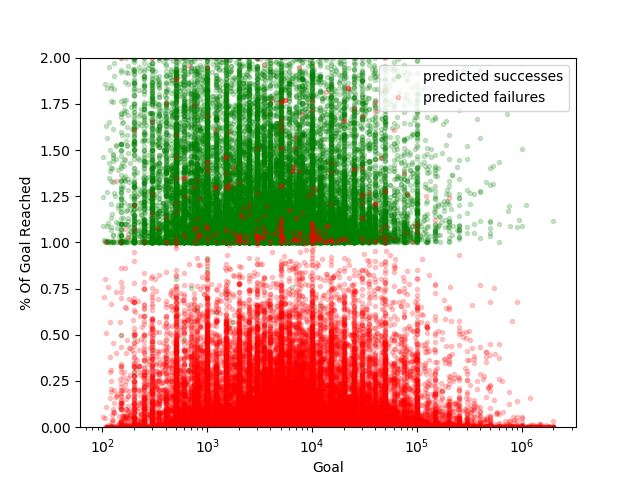

<IPython.core.display.Javascript object>


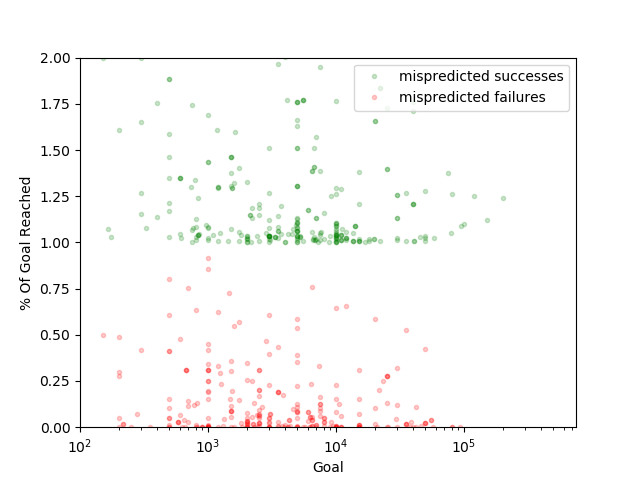

Traceback (most recent call last):
  File "<ipython-input-10-7c1f66775f8e>", line 6, in inner
    return fn(*args, **kwargs)
  File "<ipython-input-35-bb68d17deba5>", line 21, in predicted_goal_percent_comparison
    return cleaned[mispred_success | mispred_fail]
  File "/Users/iped/miniconda2/envs/py3/lib/python3.6/site-packages/pandas/core/frame.py", line 2135, in __getitem__
    return self._getitem_frame(key)
  File "/Users/iped/miniconda2/envs/py3/lib/python3.6/site-packages/pandas/core/frame.py", line 2218, in _getitem_frame
    raise ValueError('Must pass DataFrame with boolean values only')
ValueError: Must pass DataFrame with boolean values only



In [35]:
@cannot_crash
def predicted_goal_percent_comparison(clf):

    clf.fit(all_features, Y)
    pred = clf.predict(all_features)

    plt.figure()

    pred_success = cleaned[pred == 1]
    pred_failures = cleaned[pred == 0]
    goal_percent_comparison(pred_success, pred_failures)
    plt.legend(['predicted successes', 'predicted failures'])

    mispred_success = cleaned[(pred == 0) & (cleaned.state == 'successful') ]
    mispred_fail = cleaned[(pred == 1) & (cleaned.state != 'successful') ]
    plt.figure()
    goal_percent_comparison(mispred_success, mispred_fail)
    plt.legend(['mispredicted successes', 'mispredicted failures'])
    
    return cleaned[mispred_success | mispred_fail]

predicted_goal_percent_comparison()

<IPython.core.display.Javascript object>


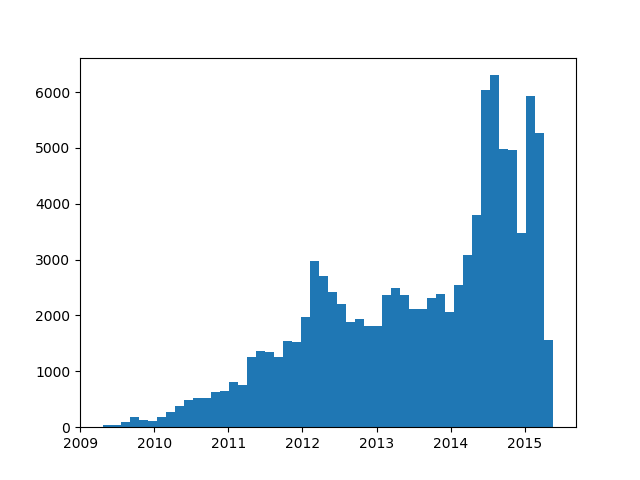

2009-04-21 17:35:35
2015-05-22 20:06:40


In [28]:
%matplotlib notebook
@cannot_crash
def show_created_at_hist():
    plt.hist(cleaned.created_at, 50)
    plt.show()
    print(cleaned.created_at.min())
    print(cleaned.created_at.max())

show_created_at_hist()

In [134]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from pprint import pprint
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

class MyDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, x_train, y_train, x_test, y_test):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.len = x_train.shape[0]
        self.x_data = torch.from_numpy(x_train).float()
        self.y_data = torch.from_numpy(y_train).long()
        
        self.x_test = torch.from_numpy(x_test).float()
        self.y_test = torch.from_numpy(y_test).long()

    def __len__(self):

        return self.len

    def __getitem__(self, idx):

        return self.x_data[idx], self.y_data[idx]    
    
class FFNet(nn.Module):
    def __init__(self, n_features, params):
        super(FFNet, self).__init__()
        layer_size = params.get('hidden', 256)
        
        self.fc1 = nn.Linear(int(n_features), layer_size)
        
        self.fc_deep = []
        for i in range(params.get('depth', 1) - 1):
            next_layer_size = int(layer_size/params.get('reduction', 2))
            self.fc_deep.append(nn.Linear(layer_size, next_layer_size))
            layer_size = next_layer_size
        
        self.fc3 = nn.Linear(layer_size, 2)

    def forward(self, x):
        out = x.view(x.shape[0], -1)
        out = F.sigmoid(self.fc1(out))
        for fc in self.fc_deep:
            out = F.sigmoid(fc(out))
        out = F.sigmoid(self.fc3(out))
        
        return out

def nn_classify(dataset, params):
    
    print("Starting classifier")
    net = FFNet(dataset.x_data.shape[1], params)
    
    train_loader = DataLoader(
        dataset=dataset,
        batch_size = params.get('batch_size', 20),
        shuffle = True
    )
    # Specify the loss function
    criterion = nn.CrossEntropyLoss()

    # Specify the optimizer
    optimizer = optim.SGD(net.parameters(),
                          lr=params.get('learning_rate', .01), 
                          momentum=params.get('momentum', .9))    
    
    max_epochs = params.get('epochs', 20)

    for epoch in range(max_epochs):
        print("Epoch %d" % epoch)
        for i, data in enumerate(train_loader, 0):
            
            inputs, labels = data
            inputs, labels = Variable(inputs), Variable(labels)
            optimizer.zero_grad()
            
            y_pred = net(inputs)
            
            loss = criterion(y_pred, torch.max(labels,1)[0])
            
            if (i % 1000) == 1:
                print("Loss: ", loss.data[0])
            
            
            loss.backward()
            
            optimizer.step()

        test_data = Variable(dataset.x_test)
        test_labels = Variable(dataset.y_test).data.numpy()

        outputs = net(test_data)
        _, predicted = torch.max(outputs.data, 1)
        total = test_labels.shape[0]
        correct = 0
        unique_predictions = set()
        for i, label in enumerate(test_labels):
            if predicted[i] == label:
                correct += 1
            unique_predictions.add(predicted[i])
        print(unique_predictions)

        epoch_accuracy = float(correct) / float(total)

        print("epoch test accuracy: ", epoch_accuracy)

    
    test_data = Variable(dataset.x_test)
    test_labels = Variable(dataset.y_test
    
    outputs = net(test_data)
    _, predicted = torch.max(outputs.data, 1)
    total = test_labels.size(0)
    correct = (predicted == dataset.y_test).sum()

    final_accuracy = float(correct) / float(total)
    
    print("Final test accuracy: ", final_accuracy)
    
    return final_accuracy
    

SyntaxError: invalid syntax (<ipython-input-134-270a28b679dd>, line 147)

In [121]:
from sklearn.model_selection import KFold

def run_nn(X, Y, n_folds=5, **params):
    print("Creating kfold")
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    p_corrects = []
    print("Folding")
    for train, test in kf.split(X):
        x_train = X[train,:]
        x_test = X[test,:]
        
        y_train = Y[train]
        y_test = Y[test]
        
        print ("Creating dataset")
        dataset = MyDataset(x_train, y_train, x_test, y_test)
        
        p_corrects.append(nn_classify(dataset, params))
        
    return p_corrects


In [122]:
Y = np.zeros(shape=(len(cleaned),1))
Y[cleaned.state == 'successful'] = 1
print(np.count_nonzero(Y), len(Y) - np.count_nonzero(Y))

43568 56186


In [81]:
run_nn(scaled_numerical_features, Y)

Creating kfold
Folding
Creating dataset
Starting classifier
Epoch 0
Loss:  0.6825822591781616
Loss:  0.5349408984184265
Loss:  0.5612034201622009
Loss:  0.5015321969985962
{0, 1}
epoch test accuracy:  0.7345997694351161
Epoch 1
Loss:  0.6534227132797241
Loss:  0.49651575088500977
Loss:  0.5893780589103699
Loss:  0.5457186698913574
{0, 1}
epoch test accuracy:  0.7365545586687384
Epoch 2
Loss:  0.456820011138916
Loss:  0.5807114243507385
Loss:  0.6329758763313293
Loss:  0.5110300183296204
{0, 1}
epoch test accuracy:  0.7374066462833944
Epoch 3
Loss:  0.5917381048202515
Loss:  0.7490186095237732
Loss:  0.5290745496749878
Loss:  0.4164946973323822
{0, 1}
epoch test accuracy:  0.7372061550799459
Epoch 4
Loss:  0.46746930480003357
Loss:  0.5467759370803833
Loss:  0.6208326816558838
Loss:  0.6402655243873596
{0, 1}
epoch test accuracy:  0.73635406746529
Epoch 5
Loss:  0.5653654932975769
Loss:  0.5625630021095276
Loss:  0.38110995292663574
Loss:  0.3904595971107483
{0, 1}
epoch test accuracy: 

KeyboardInterrupt: 

In [111]:
run_nn(text_and_scaled_numerical, Y)

Creating kfold
Folding
Creating dataset
Starting classifier
Epoch 0
Loss:  0.7147184610366821
Loss:  0.6606875658035278
Loss:  0.535128653049469
Loss:  0.5055872797966003
{0, 1}
epoch test accuracy:  0.7358528394566688
Epoch 1
Loss:  0.6573494076728821
Loss:  0.5622948408126831
Loss:  0.53288733959198
Loss:  0.6582402586936951
{0, 1}
epoch test accuracy:  0.739010575910982
Epoch 2
Loss:  0.4563456177711487
Loss:  0.6245681047439575
Loss:  0.6053516864776611
Loss:  0.5184768438339233
{0, 1}
epoch test accuracy:  0.7382587338980502
Epoch 3
Loss:  0.47375646233558655
Loss:  0.6102806329727173
Loss:  0.5333162546157837
Loss:  0.5463336706161499
{0, 1}
epoch test accuracy:  0.7386597163049471
Epoch 4
Loss:  0.5269614458084106
Loss:  0.4664013981819153
Loss:  0.6434991955757141
Loss:  0.6109210252761841
{0, 1}
epoch test accuracy:  0.7378577514911533
Epoch 5
Loss:  0.5208956599235535
Loss:  0.5343900918960571
Loss:  0.47411853075027466
Loss:  0.6241344213485718
{0, 1}
epoch test accuracy:  0

KeyboardInterrupt: 

In [117]:
run_nn(text_and_scaled_numerical, Y, learning_rate=.001, hidden=1024, batch_size=10, epochs=5)

Creating kfold
Folding
Creating dataset
Starting classifier
Epoch 0
Loss:  0.6981838941574097
Loss:  0.639136552810669
Loss:  0.7277930974960327
Loss:  0.6587914228439331
Loss:  0.6729372143745422
Loss:  0.5660527944564819
Loss:  0.6231781840324402
Loss:  0.6170529723167419
{0, 1}
epoch test accuracy:  0.731442032980803
Epoch 1
Loss:  0.5149049758911133
Loss:  0.5165958404541016
Loss:  0.6978884339332581
Loss:  0.6515159606933594
Loss:  0.5244196653366089
Loss:  0.5871027708053589
Loss:  0.4464356303215027
Loss:  0.4894797205924988
{0, 1}
epoch test accuracy:  0.7380582426946017
Epoch 2
Loss:  0.6546247005462646
Loss:  0.5694209337234497
Loss:  0.597527027130127
Loss:  0.45643386244773865
Loss:  0.5758172273635864
Loss:  0.4131811261177063
Loss:  0.4658459722995758
Loss:  0.6826313138008118
{0, 1}
epoch test accuracy:  0.7378577514911533
Epoch 3
Loss:  0.5184512138366699
Loss:  0.5309258699417114
Loss:  0.58314448595047
Loss:  0.6129629015922546
Loss:  0.5087636709213257
Loss:  0.56425

KeyboardInterrupt: 

In [126]:
run_nn(text_and_scaled_numerical, Y, learning_rate=.01, hidden=256, reduction=2, depth=2, epochs=10)

Creating kfold
Folding
Creating dataset
Starting classifier
Epoch 0
Loss:  0.6901338696479797
Loss:  0.7038262486457825
Loss:  0.6982943415641785
Loss:  0.6847082376480103
{0, 1}
epoch test accuracy:  0.639867675805724
Epoch 1
Loss:  0.6676581501960754
Loss:  0.6404693722724915
Loss:  0.5923784375190735
Loss:  0.5461252927780151
{0, 1}
epoch test accuracy:  0.7319933837902862
Epoch 2
Loss:  0.5485716462135315
Loss:  0.5210773348808289
Loss:  0.5621083378791809
Loss:  0.5957036018371582
{0, 1}
epoch test accuracy:  0.7385093479023608
Epoch 3
Loss:  0.5669731497764587
Loss:  0.5314530730247498
Loss:  0.5673077702522278
Loss:  0.5819646716117859
{0, 1}
epoch test accuracy:  0.7379579970928776
Epoch 4
Loss:  0.4859185814857483
Loss:  0.5474780201911926
Loss:  0.6068885326385498
Loss:  0.46962395310401917
{0, 1}
epoch test accuracy:  0.7387599619066714
Epoch 5
Loss:  0.5317854881286621
Loss:  0.587786078453064
Loss:  0.3982817530632019
Loss:  0.7113136053085327
{0, 1}
epoch test accuracy:  

KeyboardInterrupt: 

In [132]:
run_nn(scaled_svd, Y, learning_rate=.01, hidden=256, epochs=10)

Creating kfold
Folding
Creating dataset
Starting classifier
Epoch 0
Loss:  0.6875384449958801
Loss:  0.6418712139129639
Loss:  0.6203967332839966
Loss:  0.6492863893508911
{0, 1}
epoch test accuracy:  0.6355571149315824
Epoch 1
Loss:  0.6106522679328918
Loss:  0.5900206565856934
Loss:  0.6249173283576965
Loss:  0.6196650266647339
{0, 1}
epoch test accuracy:  0.6335020800962358
Epoch 2
Loss:  0.6345769166946411
Loss:  0.6641703844070435
Loss:  0.627580463886261
Loss:  0.6810747981071472
{0, 1}
epoch test accuracy:  0.6389153425893439
Epoch 3
Loss:  0.6498422026634216
Loss:  0.6084374189376831
Loss:  0.6143381595611572
Loss:  0.5888262987136841
{0, 1}
epoch test accuracy:  0.6417723422384843
Epoch 4
Loss:  0.6722779870033264
Loss:  0.6459130048751831
Loss:  0.6923409700393677
Loss:  0.7293860912322998
{0, 1}
epoch test accuracy:  0.6401182898100346
Epoch 5
Loss:  0.6698841452598572
Loss:  0.637536346912384
Loss:  0.5528436303138733
Loss:  0.6826015710830688
{0, 1}
epoch test accuracy:  0

KeyboardInterrupt: 

In [143]:
run_nn(scaled_svd, Y, learning_rate=.01, hidden=512, depth=2, reduction=4, epochs=10)

Creating kfold
Folding
Creating dataset
Starting classifier
Epoch 0
Loss:  0.6995352506637573
Loss:  0.6888347268104553
Loss:  0.6585656404495239
Loss:  0.6868313550949097
{0}
epoch test accuracy:  0.5700967370056639
Epoch 1
Loss:  0.6663484573364258
Loss:  0.7015472054481506
Loss:  0.701919674873352
Loss:  0.7282036542892456
{0, 1}
epoch test accuracy:  0.5709488246203198
Epoch 2
Loss:  0.6706143021583557
Loss:  0.6558045148849487
Loss:  0.6907379627227783
Loss:  0.687226414680481
{0, 1}
epoch test accuracy:  0.6551050072678061
Epoch 3
Loss:  0.6809672117233276
Loss:  0.6095945239067078
Loss:  0.6754971742630005
Loss:  0.5183638334274292
{0, 1}
epoch test accuracy:  0.6565585684928074
Epoch 4
Loss:  0.6741012334823608
Loss:  0.536851704120636
Loss:  0.6050442457199097
Loss:  0.4947487413883209
{0, 1}
epoch test accuracy:  0.6528494812290111
Epoch 5
Loss:  0.5889533758163452
Loss:  0.6827093362808228
Loss:  0.7638753652572632
Loss:  0.6130024194717407
{0, 1}
epoch test accuracy:  0.656

KeyboardInterrupt: 

In [169]:
max_size = max(max(r for r in row) for row in rows)
X_torch = np.zeros(shape=(len(rows), max_size + 2))
for i, row in enumerate(rows):
    X_torch[i, row] = 1
    X_torch[i, -1] = np.log(cleaned['goal'].iloc[i])


In [26]:
run_nn(X_torch, Y.astype(np.int32))

NameError: name 'Y' is not defined

In [45]:
from sklearn.feature_extraction.text import HashingVectorizer
# list of text documents
# create the transform
hash_size = 2048
vectorizer = HashingVectorizer(n_features=hash_size)
# encode document
X_torch = np.zeros(shape=(len(succ_fail_only), hash_size * 2))
print("Vectorizing")
descs = vectorizer.transform(succ_fail_only['desc'])
X_torch[:,:hash_size] = descs.toarray()

print("Vectorizing")
vectorizer = HashingVectorizer(n_features=hash_size)
names = vectorizer.transform(succ_fail_only['name'])
print("Iterating")
X_torch[:,hash_size:] = names.toarray()
# summarize encoded vector

Y_torch = np.zeros(shape=(len(succ_fail_only),))
Y_torch[succ_fail_only.state == 'successful'] = 1
#Y_torch[cleaned.state == 'canceled'] = 2


Vectorizing
Vectorizing
Iterating


In [49]:
X_torch[100:200,100:200][X_torch[100:200,100:200].nonzero()]

array([-0.19245009, -0.57735027,  0.2       ,  0.2       , -0.2       ,
       -0.36514837,  0.18257419, -0.18257419, -0.64051262, -0.15811388,
       -0.63245553, -0.39223227, -0.39223227, -0.22941573, -0.2773501 ,
       -0.21821789,  0.2       , -0.2       ,  0.2773501 , -0.4       ,
       -0.2236068 , -0.40824829, -0.26726124, -0.39223227, -0.31622777,
       -0.43643578, -0.20851441, -0.41702883, -0.20851441, -0.41702883,
       -0.19611614, -0.53881591, -0.35355339, -0.4       , -0.20412415,
       -0.40824829,  0.21320072, -0.42640143,  0.21320072, -0.20412415,
       -0.40824829,  0.21320072, -0.42640143,  0.21320072, -0.20412415,
       -0.40824829,  0.21320072, -0.42640143,  0.21320072, -0.20412415,
       -0.40824829,  0.21320072, -0.42640143,  0.21320072, -0.20412415,
       -0.40824829,  0.21320072, -0.42640143,  0.21320072,  0.16666667,
       -0.5       ,  0.18257419, -0.54772256,  0.24253563, -0.18569534,
       -0.20851441,  0.20851441,  0.1796053 , -0.1796053 ,  0.20

In [121]:
import random
def sample_equally(X, Y):
    n1 = np.count_nonzero(Y)
    n0 = len(Y) - n1
    
    if n0 > n1:
        zs = np.arange(len(Y))[Y==0]
        rm_inds = zs[random.sample(range(n0),n0 - n1)]
    elif n1 > n0:
        nzs = (Y==1).nonzero()
        rm_inds = nzs[random.sample(range(n1), n1 - n0)]
        
    X = np.delete(X, rm_inds, axis=0)
    return X, np.delete(Y, rm_inds)

X_sampled, Y_sampled = sample_equally(X_torch, Y_torch)

(array([    0,     0,     0, ..., 87135, 87135, 87135]),
 array([ 152,  228,  300, ..., 3081, 3257, 3895]))

In [122]:
X_all = np.concatenate([X_torch], 1)



run_nn(X_sampled, Y_sampled)

Creating kfold
Folding
Creating dataset
Starting classifier
Epoch 0
Loss:  0.6930519342422485
Loss:  0.6936595439910889
Loss:  0.6933972835540771
Loss:  0.6930513381958008
{0}
epoch test accuracy:  0.49741794812944684
Epoch 1
Loss:  0.6950222253799438
Loss:  0.6932680010795593


KeyboardInterrupt: 

In [94]:
run_nn(features_no_text.todense(), Y_torch)

Creating kfold
Folding
Creating dataset
Starting classifier
Epoch 0
Loss:  0.7149047255516052
Loss:  0.6235060095787048
Loss:  0.6768231987953186
Loss:  0.71131432056427
Loss:  0.6950801610946655
Loss:  0.6613279581069946
Loss:  0.6960049867630005
Loss:  0.6963950395584106
{0}
epoch test accuracy:  0.5448225007900558
Epoch 1
Loss:  0.6876341104507446
Loss:  0.6950832605361938
Loss:  0.6990638971328735
Loss:  0.6955081820487976
Loss:  0.6845874786376953
Loss:  0.6691179275512695
Loss:  0.6877443790435791
Loss:  0.7109284996986389
{0, 1}
epoch test accuracy:  0.560570947013589
Epoch 2
Loss:  0.6226317882537842
Loss:  0.5901790261268616
Loss:  0.6484287977218628
Loss:  0.6113727688789368
Loss:  0.7064258456230164
Loss:  0.7472276091575623
Loss:  0.7828632593154907
Loss:  0.5210118889808655
{0, 1}
epoch test accuracy:  0.6242494469609186
Epoch 3
Loss:  0.5328080058097839
Loss:  0.5145958662033081
Loss:  0.5972114205360413
Loss:  0.7431961297988892
Loss:  0.5098970532417297
Loss:  0.6260768

KeyboardInterrupt: 

In [202]:
run_nn(features_no_text.todense(), Y_torch)

Creating kfold
Folding
Creating dataset
Starting classifier
Epoch 0
Loss:  0.6920455694198608
Loss:  0.7073584794998169


KeyboardInterrupt: 

In [123]:
no_text_X_sampled, Y_torch_sampled = sample_equally(features_no_text.todense(), Y_torch)

In [128]:
run_nn(no_text_X_sampled, Y_torch_sampled)

Creating kfold
Folding
Creating dataset
Starting classifier
Epoch 0
Loss:  0.682822048664093
Loss:  0.695063591003418
Loss:  0.6892836689949036
Loss:  0.6852731704711914
{0, 1}
epoch test accuracy:  0.5200826256598577
Epoch 1
Loss:  0.6807538270950317
Loss:  0.6799079179763794
Loss:  0.6930932402610779
Loss:  0.6769686937332153
{0, 1}
epoch test accuracy:  0.5516984163415194
Epoch 2
Loss:  0.6878217458724976
Loss:  0.6745928525924683
Loss:  0.6732357740402222
Loss:  0.6472839713096619
{0, 1}
epoch test accuracy:  0.5912324994262107
Epoch 3
Loss:  0.6744797825813293
Loss:  0.6895471811294556
Loss:  0.6928130984306335
Loss:  0.6455806493759155
{0, 1}
epoch test accuracy:  0.604888684874914
Epoch 4
Loss:  0.67804354429245
Loss:  0.6812614798545837
Loss:  0.6062023043632507
Loss:  0.6793414354324341
{0, 1}
epoch test accuracy:  0.6066674317190728
Epoch 5
Loss:  0.6453382968902588
Loss:  0.6622499227523804
Loss:  0.6882236003875732
Loss:  0.6534063816070557
{0, 1}
epoch test accuracy:  0.59

KeyboardInterrupt: 

In [212]:
from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer(max_features=16384)

desc_features = v.fit_transform(succ_fail_only['desc'])
name_features = v.fit_transform(succ_fail_only['name'])


In [ ]:
str_features = np.concatenate([desc_features.todense(), name_features.todense()], 1)

In [178]:
from scipy.sparse import hstack
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(512)
X_svd = svd.fit_transform(hstack([desc_features, name_features]))

In [210]:
from sklearn.decomposition import PCA

pca = PCA(512)
X_pca = pca.fit_transform(np.concatenate([str_features, features_no_text.todense()],1))


In [190]:
Y_torch.shape, name_features, desc_features

((94928,), <94928x2048 sparse matrix of type '<class 'numpy.float64'>'
 	with 333167 stored elements in Compressed Sparse Row format>, <94928x2048 sparse matrix of type '<class 'numpy.float64'>'
 	with 1293431 stored elements in Compressed Sparse Row format>)

In [211]:
x_text_equal, y_text_equal= sample_equally(X_pca, Y_torch)
run_nn(x_text_equal, y_text_equal)

Creating kfold
Folding
Creating dataset
Starting classifier
Epoch 0
Loss:  0.6891080141067505
Loss:  0.6950901746749878
Loss:  0.6897500157356262
Loss:  0.7046384811401367
{0, 1}
epoch test accuracy:  0.5685104429653431
Epoch 1
Loss:  0.747378408908844
Loss:  0.6142457723617554
Loss:  0.6689587831497192
Loss:  0.6869531869888306
{0, 1}
epoch test accuracy:  0.6470621987606151
Epoch 2
Loss:  0.6590135097503662
Loss:  0.5931385159492493
Loss:  0.5871032476425171
Loss:  0.5200247168540955
{0, 1}
epoch test accuracy:  0.6913587330732155
Epoch 3
Loss:  0.6386398077011108
Loss:  0.5571799874305725
Loss:  0.6175441741943359
Loss:  0.49692511558532715
{0, 1}
epoch test accuracy:  0.6873995868717007
Epoch 4
Loss:  0.5741495490074158
Loss:  0.6250993013381958
Loss:  0.5956780314445496
Loss:  0.6424252390861511
{0, 1}
epoch test accuracy:  0.7070231810879045
Epoch 5
Loss:  0.5718030333518982
Loss:  0.6099616289138794
Loss:  0.6191413402557373
Loss:  0.5381216406822205
{0, 1}
epoch test accuracy: 

KeyboardInterrupt: 

In [167]:
run_classifier(X_svd, Y, RandomForestClassifier())

	Fold accuracy: 0.675
	Fold accuracy: 0.690
	Fold accuracy: 0.681


KeyboardInterrupt: 